### Inport necessary packages

In [52]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [53]:
import matplotlib.pyplot as plt

In [54]:
import random
import numpy as np

In [55]:
import torch.nn as nn
import torch.nn.functional as F

In [56]:
import os
import cv2

In [57]:
seed = 21521109

In [58]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load Folio Leaf Dataset

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
root_dir = '/content/drive/MyDrive/CS115/Dataset/Folio Leaf Dataset/' # Example: '/content/drive/MyDrive/CS115/DatasetDataset/Folio Leaf Dataset'

In [61]:
list_folders = os.listdir(root_dir)
list_folders

['betel',
 'chrysanthemum',
 'barbados cherry',
 'coeur demoiselle',
 'ashanti blood',
 'chinese guava',
 'beaumier du perou',
 'bitter orange',
 'chocolate tree',
 'caricature plant',
 'coffee',
 'jackfruit',
 'fruitcitere',
 'duranta gold',
 'guava',
 'croton',
 'hibiscus',
 'ficus',
 'geranium',
 'eggplant',
 'sweet olive',
 'papaya',
 'ketembilla',
 'pomme jacquot',
 'pimento',
 'lychee',
 'star apple',
 'sweet potato',
 'rose',
 'mulberry leaf',
 'vieux garcon',
 'thevetia']

In [62]:
def resize(image):
    return cv2.resize(image, (232, 412))

### Process the raw data

In [63]:
# Create dataset (X, y)
X, y = [], []
for folder in list_folders:
  list_image_paths = os.listdir(root_dir + '/' + folder)
  for image_path in list_image_paths:
    img_matrix = resize(cv2.imread(root_dir + '/' + folder + '/' + image_path, 0))
    X.append([img_matrix])
    y.append(folder)

In [64]:
# Task: Normalize the value of each pixel by dividing them to 255
X_leaf = np.array(X)/255

In [65]:
# Task: Perform 'label encoding' on y
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [66]:
y = le.fit_transform(y)

### Create the train/test set

In [67]:
# Task: Split dataset into training and testing set (7:3, random_seed = Your Student ID)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_leaf, y, train_size=0.7, random_state=21521109)

In [68]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

In [69]:
# Task: Convert the data type of X_train, X_test, y_train, y_test to 'Tensor'
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [70]:
# Task: Create train_dataset, test_dataset
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [71]:
# Task: Create train_loader (batch_size = 64), test_loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset)

### Implement Classifiers

In [72]:
# Task: Implement "Logistic Regression" model with PyTorch
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.Linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        logits = self.Linear(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [73]:
import torch.optim as optim

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [75]:
# Task: Design the 'model_evaluation' function for evaluating the trained models
def model_evaluation(data_loader, model):
    nCorrects = 0;
    model.eval()
    with torch.no_grad():
        for (imgs, labels) in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.reshape(imgs.shape[0],-1)

            #forward
            _, probs = model(imgs)
            _, y_pred = probs.max(1)
            nCorrects += (y_pred == labels).sum()
    print(f'We got {nCorrects.item()}/{len(data_loader.dataset)} correct. Accuracy = {nCorrects.item()/len(data_loader.dataset) * 100:.2f}%')

In [76]:
# Task: Design the 'train_model' function for training models
# Loss Function: Cross Entropy Loss
# Optimizer: Adam -> optim.Adam(model.parameters(), lr=...)
def train_model(dataloader, model, init_lr, max_epoch):
    critetion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = init_lr)
    loss_each_epoch = []
    model.train()
    for epoch in range(max_epoch):
        sumloss = 0.0
        for(imgs, labels) in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.reshape(imgs.shape[0],-1)
            #forward 
            logits, _ = model(imgs)
            loss = critetion(logits,labels)
            #backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            sumloss+= loss.item()
        loss_each_epoch.append(sumloss/len(dataloader.dataset))
        print(f'Epoch {epoch+1}\{max_epoch}, Loss {loss_each_epoch[-1]:.2} ')
    return loss_each_epoch

In [77]:
# Train Logistic Regression model
# Input dim = 412 * 232
# Output dim = 32
# Initial Learning Rate: 0.001
# Max Epoch = 600
Init_lr =  0.001
Input_dim = 412*232
Output_dim = 32
Max_epoch = 600
clf_LR = LogisticRegression(input_dim= Input_dim,  output_dim=Output_dim).to(device)
loss_each_epoch_LR = train_model(train_loader, clf_LR, Init_lr, Max_epoch)

Epoch 1\600, Loss 0.23 
Epoch 2\600, Loss 3.5 
Epoch 3\600, Loss 3.5 
Epoch 4\600, Loss 3.1 
Epoch 5\600, Loss 2.0 
Epoch 6\600, Loss 1.8 
Epoch 7\600, Loss 3.0 
Epoch 8\600, Loss 1.7 
Epoch 9\600, Loss 2.4 
Epoch 10\600, Loss 2.3 
Epoch 11\600, Loss 1.5 
Epoch 12\600, Loss 1.2 
Epoch 13\600, Loss 0.95 
Epoch 14\600, Loss 1.0 
Epoch 15\600, Loss 1.4 
Epoch 16\600, Loss 2.0 
Epoch 17\600, Loss 0.9 
Epoch 18\600, Loss 0.82 
Epoch 19\600, Loss 0.68 
Epoch 20\600, Loss 1.0 
Epoch 21\600, Loss 1.3 
Epoch 22\600, Loss 0.64 
Epoch 23\600, Loss 0.74 
Epoch 24\600, Loss 0.6 
Epoch 25\600, Loss 0.66 
Epoch 26\600, Loss 1.3 
Epoch 27\600, Loss 0.87 
Epoch 28\600, Loss 1.6 
Epoch 29\600, Loss 0.47 
Epoch 30\600, Loss 0.41 
Epoch 31\600, Loss 0.45 
Epoch 32\600, Loss 0.39 
Epoch 33\600, Loss 1.3 
Epoch 34\600, Loss 0.27 
Epoch 35\600, Loss 0.29 
Epoch 36\600, Loss 0.62 
Epoch 37\600, Loss 0.32 
Epoch 38\600, Loss 0.39 
Epoch 39\600, Loss 0.38 
Epoch 40\600, Loss 1.1 
Epoch 41\600, Loss 0.33 
Epoch 

Text(0.5, 1.0, 'LogisticRegression')

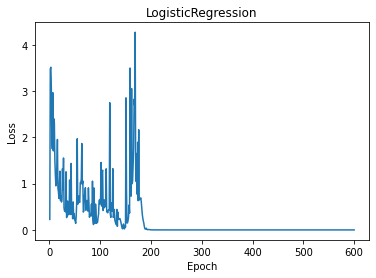

In [89]:
plt.plot(range(1, len(loss_each_epoch_LR) + 1), loss_each_epoch_LR)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LogisticRegression')

In [90]:
print('Logistic Regression (Train Accuracy)')
model_evaluation(data_loader=train_loader, model=clf_LR)

Logistic Regression (Train Accuracy)
We got 129/129 correct. Accuracy = 100.00%


In [80]:
print('Logistic Regression (Test Accuracy)')
model_evaluation(data_loader=test_loader, model=clf_LR)

Logistic Regression (Test Accuracy)
We got 39/56 correct. Accuracy = 69.64%


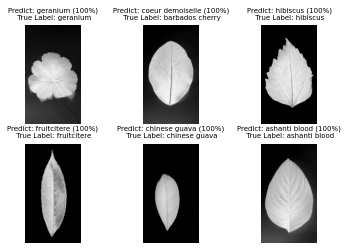

In [81]:
ROW_IMG, N_ROWS = 3, 2

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset[index][0].squeeze(), cmap='gray_r')
    
    with torch.no_grad():
        clf_LR.eval()
        X = test_dataset[index][0].reshape(test_dataset[index][0].shape[0], -1).to(device)
        _, probs = clf_LR(X)
    title = f'Predict: {le.inverse_transform([torch.argmax(probs).item()])[0]} ({torch.max(probs * 100):.0f}%)\n True Label: {le.inverse_transform([test_dataset[index][-1]])[0]}'
    
    plt.title(title, fontsize=7)
plt.show()

In [82]:
# Task: Build a MLP model with 6 layers (input layer, ouput layer and 4 hidden layers)
# The activation of each node in 'input' layer and 'hidden' layers is ReLU
# Information about each layer:
# + Input layer: (input_dim, 2048)
# + Hidden layer 1: (2048, 1024)
# + Hidden layer 2: (1024, 1024)
# + Hidden layer 3: (1024, 512)
# + Hidden layer 4: (512, 512)
# + Output layer: (512, output_dim)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.classifier = nn.Sequential(nn.Linear(input_dim, 2048),
                                        nn.ReLU(),
                                        nn.Linear(2048, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024,512),
                                        nn.ReLU(),
                                        nn.Linear(512, 512),
                                        nn.ReLU(),
                                        nn.Linear(512, output_dim)
                                        )
    def forward(self, x):
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [83]:
clf_MLP = MLP(input_dim=412 * 232, output_dim=32).to(device)
clf_MLP

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=95584, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=32, bias=True)
  )
)

In [84]:
# Train MLP model
# Input dim = 412 * 233
# Output dim = 32
# Initial Learning Rate: 0.001
# Max Epoch = 600
loss_each_epoch_MLP = train_model(train_loader,clf_MLP, init_lr=Init_lr, max_epoch=600)

Epoch 1\600, Loss 0.1 
Epoch 2\600, Loss 0.29 
Epoch 3\600, Loss 0.093 
Epoch 4\600, Loss 0.07 
Epoch 5\600, Loss 0.072 
Epoch 6\600, Loss 0.068 
Epoch 7\600, Loss 0.069 
Epoch 8\600, Loss 0.073 
Epoch 9\600, Loss 0.067 
Epoch 10\600, Loss 0.074 
Epoch 11\600, Loss 0.073 
Epoch 12\600, Loss 0.07 
Epoch 13\600, Loss 0.062 
Epoch 14\600, Loss 0.069 
Epoch 15\600, Loss 0.059 
Epoch 16\600, Loss 0.066 
Epoch 17\600, Loss 0.064 
Epoch 18\600, Loss 0.063 
Epoch 19\600, Loss 0.065 
Epoch 20\600, Loss 0.06 
Epoch 21\600, Loss 0.069 
Epoch 22\600, Loss 0.064 
Epoch 23\600, Loss 0.06 
Epoch 24\600, Loss 0.073 
Epoch 25\600, Loss 0.066 
Epoch 26\600, Loss 0.063 
Epoch 27\600, Loss 0.059 
Epoch 28\600, Loss 0.07 
Epoch 29\600, Loss 0.074 
Epoch 30\600, Loss 0.066 
Epoch 31\600, Loss 0.062 
Epoch 32\600, Loss 0.053 
Epoch 33\600, Loss 0.074 
Epoch 34\600, Loss 0.059 
Epoch 35\600, Loss 0.061 
Epoch 36\600, Loss 0.067 
Epoch 37\600, Loss 0.062 
Epoch 38\600, Loss 0.064 
Epoch 39\600, Loss 0.06 
Epoc

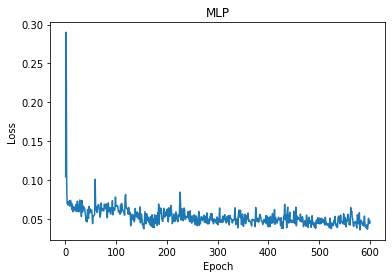

In [85]:
def LossPlot(loss_each_epoch, Name:str):
  plt.plot(range(1, len(loss_each_epoch_MLP) + 1), loss_each_epoch_MLP)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(Name)
  plt.show()
LossPlot(loss_each_epoch_MLP,'MLP')

In [86]:
print('Multi Layer Perceptron (Train Accuracy)')
model_evaluation(train_loader, clf_MLP)

Multi Layer Perceptron (Train Accuracy)
We got 35/129 correct. Accuracy = 27.13%


In [87]:
print('Multi Layer Perceptron (Test Accuracy)')
model_evaluation(test_loader, clf_MLP)

Multi Layer Perceptron (Test Accuracy)
We got 12/56 correct. Accuracy = 21.43%


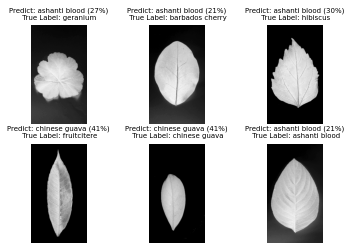

In [88]:
ROW_IMG, N_ROWS = 3, 2

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset[index][0].squeeze(), cmap='gray_r')
    
    with torch.no_grad():
        clf_MLP.eval()
        X = test_dataset[index][0].reshape(test_dataset[index][0].shape[0], -1).to(device)
        _, probs = clf_MLP(X)
    title = f'Predict: {le.inverse_transform([torch.argmax(probs).item()])[0]} ({torch.max(probs * 100):.0f}%)\n True Label: {le.inverse_transform([test_dataset[index][-1]])[0]}'
    
    plt.title(title, fontsize=7)
plt.show()